## importing python libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## loading the datasets

In [2]:
items_details= pd.read_csv("Items.csv")
price_details= pd.read_csv("PriceAdjustments.csv")
sale_details= pd.read_csv("SampleSales.csv")

## Information about the dataset

In [3]:
items_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9205 entries, 0 to 9204
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ItemID       9205 non-null   object
 1   Period       9205 non-null   object
 2   Category     9205 non-null   object
 3   SubCategory  9205 non-null   object
 4   Type         9205 non-null   object
 5   SubType      9205 non-null   object
dtypes: object(6)
memory usage: 431.6+ KB


In [4]:
price_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25809 entries, 0 to 25808
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ItemID          25809 non-null  object 
 1   year            25809 non-null  int64  
 2   WeekIdentifier  25809 non-null  int64  
 3   SalesChannel    25809 non-null  object 
 4   Territory       25809 non-null  object 
 5   BasePrice       25809 non-null  float64
 6   PrevBasePrice   25809 non-null  float64
 7   NewBasePrice    25809 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 1.6+ MB


In [5]:
sale_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44167 entries, 0 to 44166
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ItemID                  44167 non-null  object 
 1   year                    44167 non-null  int64  
 2   WeekIdentifier          44167 non-null  int64  
 3   SalesChannel            44167 non-null  object 
 4   Territory               44167 non-null  object 
 5   NewBasePrice            44167 non-null  float64
 6   TotalInventory          44167 non-null  int64  
 7   StoreInventory          44167 non-null  int64  
 8   WarehouseInventory      44167 non-null  int64  
 9   StockedStorePercentage  44167 non-null  float64
 10  SellingStoresRatio      44167 non-null  float64
 11  InboundInventory        44167 non-null  int64  
 12  SalesQuantity           44167 non-null  int64  
 13  ProjectedInventory      44167 non-null  int64  
dtypes: float64(3), int64(8), object(3)
mem

## Merged three datasets based on condition

In [6]:
#Merge sales + price data
sales_price_merged = sale_details.merge(
    price_details,
    on=["ItemID", "year", "WeekIdentifier", "SalesChannel", "Territory"],
    how="left",
    suffixes=("", "_price"))

In [7]:
#Merge item hierarchy data
final_merged_df = sales_price_merged.merge(
    items_details,
    on="ItemID",
    how="left")

## Information about the merged dataset

In [8]:
final_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44167 entries, 0 to 44166
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ItemID                  44167 non-null  object 
 1   year                    44167 non-null  int64  
 2   WeekIdentifier          44167 non-null  int64  
 3   SalesChannel            44167 non-null  object 
 4   Territory               44167 non-null  object 
 5   NewBasePrice            44167 non-null  float64
 6   TotalInventory          44167 non-null  int64  
 7   StoreInventory          44167 non-null  int64  
 8   WarehouseInventory      44167 non-null  int64  
 9   StockedStorePercentage  44167 non-null  float64
 10  SellingStoresRatio      44167 non-null  float64
 11  InboundInventory        44167 non-null  int64  
 12  SalesQuantity           44167 non-null  int64  
 13  ProjectedInventory      44167 non-null  int64  
 14  BasePrice               2825 non-null 

In [9]:
final_merged_df.head()

,ItemID,year,WeekIdentifier,SalesChannel,Territory,NewBasePrice,TotalInventory,StoreInventory,WarehouseInventory,StockedStorePercentage,...,SalesQuantity,ProjectedInventory,BasePrice,PrevBasePrice,NewBasePrice_price,Period,Category,SubCategory,Type,SubType
0,XebtiUQ79,2018,2,Stores,AXX,14.373,43,9,34,0.1870,...,4,0,NaN,NaN,NaN,SunnySeason,4ThiCT_Z,Mm5PoR88,Z9P2fsUr,go3tLx3Z
1,bjbkqqM42,2018,2,E-commerce,AXX,15.753,6,0,6,0.0989,...,3,0,NaN,NaN,NaN,SunnySeason,HZlnatsW,yo2ZtUyf,S0dh3b7U,xkDdhdEq
2,1d_OHvY71,2018,2,Stores,YXX,14.913,4,4,0,0.0390,...,0,0,NaN,NaN,NaN,SunnySeason,xF4EZaTy,AunzRwr2,vDXSfxVP,wY04gZ3u
3,sC6CR9s11,2018,2,Stores,YXX,15.722,7,0,7,0.0460,...,3,0,NaN,NaN,NaN,SunnySeason,HZlnatsW,14iCK1vp,VXU0TYBT,C_k1sRf5
4,bjtzCho93,2018,2,E-commerce,AXX,21.383,7,2,5,0.0149,...,4,0,NaN,NaN,NaN,SunnySeason,HZlnatsW,yo2ZtUyf,S0dh3b7U,oT7MJnDF


## Finding null values

In [10]:
final_merged_df.isnull().sum()

ItemID                        0
year                          0
WeekIdentifier                0
SalesChannel                  0
Territory                     0
NewBasePrice                  0
TotalInventory                0
StoreInventory                0
WarehouseInventory            0
StockedStorePercentage        0
SellingStoresRatio            0
InboundInventory              0
SalesQuantity                 0
ProjectedInventory            0
BasePrice                 41342
PrevBasePrice             41342
NewBasePrice_price        41342
Period                        0
Category                      0
SubCategory                   0
Type                          0
SubType                       0
dtype: int64

### Dropping missing value 

In [11]:
final_merged_df.drop(
    columns=["BasePrice", "PrevBasePrice", "NewBasePrice_price"],
    inplace=True)

## Finding duplicate values

In [12]:
final_merged_df.duplicated(
    subset=["ItemID", "year", "WeekIdentifier", "SalesChannel", "Territory"]).sum()

0

## Data visualisation

### Weekly Sales Trend

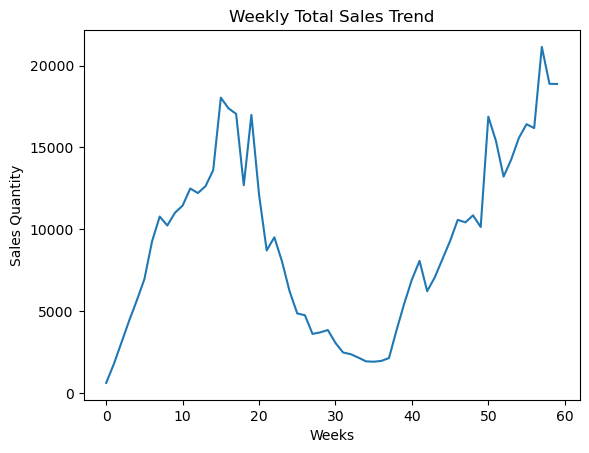

In [13]:
weekly_sales = (final_merged_df
    .groupby(["year", "WeekIdentifier"])["SalesQuantity"]
    .sum()
    .reset_index())
plt.figure()
plt.plot(weekly_sales["SalesQuantity"])
plt.title("Weekly Total Sales Trend")
plt.xlabel("Weeks")
plt.ylabel("Sales Quantity")
plt.show()

### Total Sales by Product Category

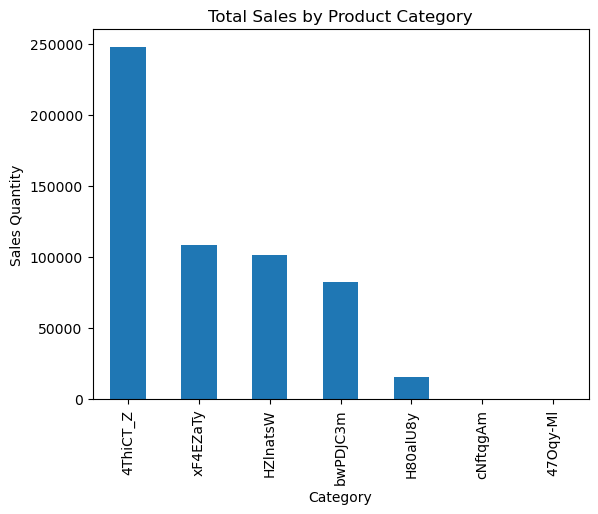

In [14]:
category_sales = (final_merged_df
    .groupby("Category")["SalesQuantity"]
    .sum()
    .sort_values(ascending=False))
plt.figure()
category_sales.plot(kind="bar")
plt.title("Total Sales by Product Category")
plt.xlabel("Category")
plt.ylabel("Sales Quantity")
plt.show()

### Inventory vs Sales Quantity (Waste Risk)

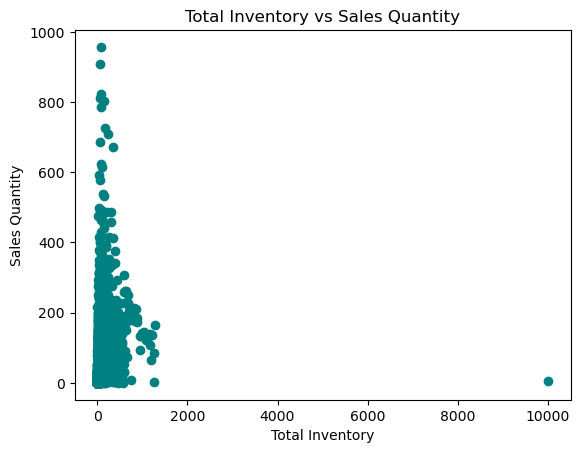

In [15]:
plt.figure()
plt.scatter(
    final_merged_df["TotalInventory"],
    final_merged_df["SalesQuantity"], color="teal")
plt.title("Total Inventory vs Sales Quantity")
plt.xlabel("Total Inventory")
plt.ylabel("Sales Quantity")
plt.show()

### Price vs Sales Quantity (Demand Sensitivity)

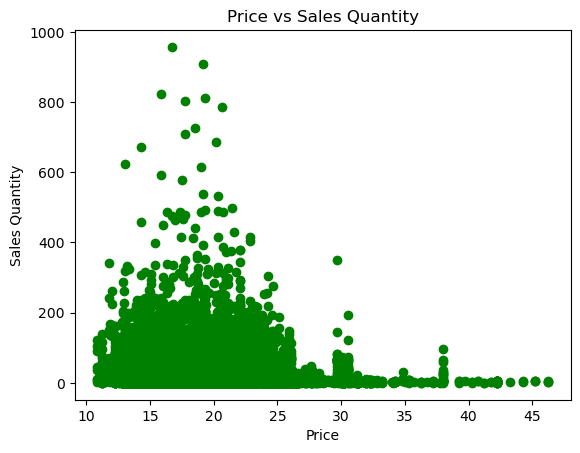

In [16]:
plt.figure()
plt.scatter(
    final_merged_df["NewBasePrice"],
    final_merged_df["SalesQuantity"], color="green")
plt.title("Price vs Sales Quantity")
plt.xlabel("Price")
plt.ylabel("Sales Quantity")
plt.show()

### Projected Inventory vs Actual Sales (Forecast Accuracy)

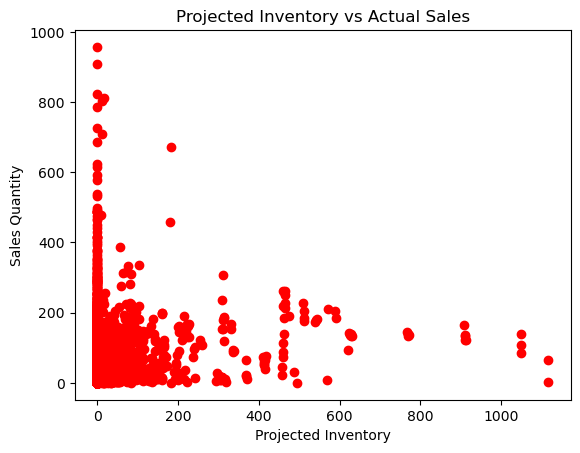

In [17]:
plt.figure()
plt.scatter(
    final_merged_df["ProjectedInventory"],
    final_merged_df["SalesQuantity"], color="red")
plt.title("Projected Inventory vs Actual Sales")
plt.xlabel("Projected Inventory")
plt.ylabel("Sales Quantity")
plt.show()

### Feature engineering

In [18]:
final_merged_df = final_merged_df.sort_values(
    by=["ItemID", "year", "WeekIdentifier"]).reset_index(drop=True)  #sorting the dataset

#### Lag Features (Past demand influences future demand)

In [19]:
final_merged_df["Sales_Lag_1"] = (
    final_merged_df
    .groupby("ItemID")["SalesQuantity"]
    .shift(1))
final_merged_df["Sales_Lag_2"] = (
    final_merged_df
    .groupby("ItemID")["SalesQuantity"]
    .shift(2))
final_merged_df["Sales_Lag_4"] = (
    final_merged_df
    .groupby("ItemID")["SalesQuantity"]
    .shift(4))

#### Rolling Averages (Demand smoothing & seasonality)

In [20]:
final_merged_df["Sales_Rolling_4"] = (
    final_merged_df
    .groupby("ItemID")["SalesQuantity"]
    .rolling(window=4)
    .mean()
    .reset_index(level=0, drop=True))
final_merged_df["Sales_Rolling_8"] = (
    final_merged_df
    .groupby("ItemID")["SalesQuantity"]
    .rolling(window=8)
    .mean()
    .reset_index(level=0, drop=True))

#### Price Change Feature

In [21]:
final_merged_df["Price_Change"] = (
    final_merged_df
    .groupby("ItemID")["NewBasePrice"]
    .pct_change())

In [22]:
final_merged_df["Price_Changed_Flag"] = (
    final_merged_df["Price_Change"] != 0).astype(int)

#### Clean the dataset

In [23]:
final_merged_df = final_merged_df.dropna().reset_index(drop=True)

In [24]:
final_merged_df.info()  # information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37700 entries, 0 to 37699
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ItemID                  37700 non-null  object 
 1   year                    37700 non-null  int64  
 2   WeekIdentifier          37700 non-null  int64  
 3   SalesChannel            37700 non-null  object 
 4   Territory               37700 non-null  object 
 5   NewBasePrice            37700 non-null  float64
 6   TotalInventory          37700 non-null  int64  
 7   StoreInventory          37700 non-null  int64  
 8   WarehouseInventory      37700 non-null  int64  
 9   StockedStorePercentage  37700 non-null  float64
 10  SellingStoresRatio      37700 non-null  float64
 11  InboundInventory        37700 non-null  int64  
 12  SalesQuantity           37700 non-null  int64  
 13  ProjectedInventory      37700 non-null  int64  
 14  Period                  37700 non-null

#### Split the dataset

In [25]:
y = final_merged_df["SalesQuantity"]  #target column
feature_cols = [
    # Price feature
    "NewBasePrice",
    "Price_Changed_Flag",
    # Inventory context 
    "TotalInventory",
    "StoreInventory",
    "WarehouseInventory",
    # Lag features
    "Sales_Lag_1",
    "Sales_Lag_2",
    "Sales_Lag_4",
    # Rolling averages
    "Sales_Rolling_4",
    "Sales_Rolling_8",
    # Distribution coverage
    "StockedStorePercentage",
    "SellingStoresRatio"]
X = final_merged_df[feature_cols]

In [26]:
final_merged_df["TimeIndex"] = (
    final_merged_df["year"].astype(str) +
    "-" +
    final_merged_df["WeekIdentifier"].astype(str))

##### Data splitting

In [27]:
total_rows = len(final_merged_df)
train_end = int(total_rows * 0.70)
val_end = int(total_rows * 0.85)

In [28]:
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

In [29]:
print(X_train.shape, X_val.shape, X_test.shape)

(26390, 12) (5655, 12) (5655, 12)


## Random forest classifier

In [30]:
tscv = TimeSeriesSplit(n_splits=5)
#time-series cross-validation

In [31]:
rf_demand = RandomForestRegressor(
    random_state=42,
    n_jobs=-1)

In [32]:
param_dist = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]}
random_search_rf = RandomizedSearchCV(
    estimator=rf_demand,
    param_distributions=param_dist,
    n_iter=20,                    
    cv=tscv,
    scoring="neg_mean_squared_error",
    random_state=42,
    n_jobs=-1)
random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='neg_mean_squared_error')

In [33]:
#Best model from tuning
best_rf = random_search_rf.best_estimator_
print("Best Parameters:", random_search_rf.best_params_)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}


In [34]:
#Validate on validation set
y_val_pred_rf = best_rf.predict(X_val)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)
print("Validation MSE of RF:", val_mse_rf) 
print("Validation R² of RF:", val_r2_rf)

Validation MSE of RF: 126.19974851012275
Validation R² of RF: 0.9015999717207037


In [35]:
y_test_pred_rf = best_rf.predict(X_test)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)
print("Random Forest model evaluation")
print("Test MSE:", test_mse_rf)
print("Test R²:", test_r2_rf)

Random Forest model evaluation
Test MSE: 149.4243892878404
Test R²: 0.8539094756179073


#### Feature importance

                   Feature  Importance
11      SellingStoresRatio    0.577568
8          Sales_Rolling_4    0.333159
3           StoreInventory    0.014842
5              Sales_Lag_1    0.014048
2           TotalInventory    0.012397
7              Sales_Lag_4    0.010589
10  StockedStorePercentage    0.009172
9          Sales_Rolling_8    0.008930
6              Sales_Lag_2    0.007479
4       WarehouseInventory    0.005596
0             NewBasePrice    0.005206
1       Price_Changed_Flag    0.001014


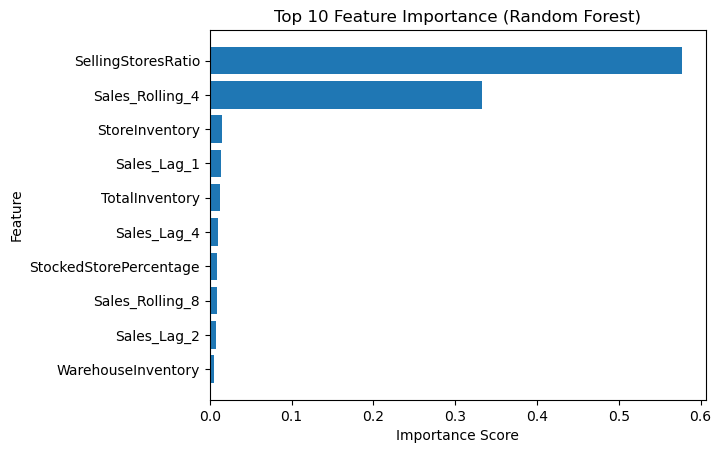

In [36]:
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_rf.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(feature_importance)
top_features_rf = feature_importance.head(10)
plt.figure()
plt.barh(
    top_features_rf["Feature"],
    top_features_rf["Importance"])
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## XGBoost

In [37]:
xgb_model_demand = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1)

In [38]:
param_dist = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]}
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model_demand,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_mean_squared_error",
    cv=3,                
    random_state=42,
    n_jobs=-1)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [200, 300, 500],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error')

In [39]:
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters:", random_search_xgb.best_params_)

Best Parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [40]:
#Validation performance
y_val_pred = best_xgb.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print("Validation MSE:", val_mse)
print("Validation R²:", val_r2)

Validation MSE: 137.7137161926408
Validation R²: 0.8926223516464233


In [41]:
#Final evaluation on TEST set
y_test_pred = best_xgb.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("XGBoost model evaluation")
print("Test MSE:", test_mse)
print("Test R²:", test_r2)

XGBoost model evaluation
Test MSE: 137.78079665550723
Test R²: 0.8652932643890381


#### Feature importance

                   Feature  Importance
11      SellingStoresRatio    0.396660
3           StoreInventory    0.171822
8          Sales_Rolling_4    0.168967
9          Sales_Rolling_8    0.076767
1       Price_Changed_Flag    0.053120
2           TotalInventory    0.031968
10  StockedStorePercentage    0.022382
5              Sales_Lag_1    0.022063
6              Sales_Lag_2    0.016724
7              Sales_Lag_4    0.016661
4       WarehouseInventory    0.011591
0             NewBasePrice    0.011276


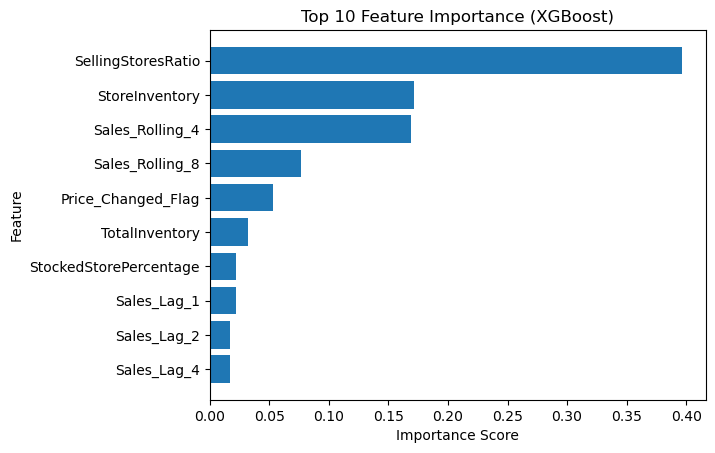

In [42]:
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_xgb.feature_importances_
}).sort_values(by="Importance", ascending=False)
print(feature_importance)
top_features = feature_importance.head(10)
plt.figure()
plt.barh(
    top_features["Feature"],
    top_features["Importance"])
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

## LSTM

In [43]:
X = final_merged_df[feature_cols]
y = final_merged_df["SalesQuantity"].values
total_rows = len(final_merged_df)
train_end = int(total_rows * 0.70)
val_end = int(total_rows * 0.85)
X_train = X.iloc[:train_end]
y_train = y[:train_end]
X_val = X.iloc[train_end:val_end]
y_val = y[train_end:val_end]
X_test = X.iloc[val_end:]
y_test = y[val_end:]

In [44]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [45]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_lstm = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [46]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train_lstm.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(
    optimizer="adam",
    loss="mse")

In [47]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True)
history = model.fit(
    X_train_lstm,
    y_train_scaled,
    validation_data=(X_val_lstm, y_val_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1)

Epoch 1/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.7773e-04 - val_loss: 4.6727e-04
Epoch 2/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.1955e-04 - val_loss: 3.7150e-04
Epoch 3/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6437e-04 - val_loss: 3.5536e-04
Epoch 4/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 2.4305e-04 - val_loss: 2.8682e-04
Epoch 5/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2056e-04 - val_loss: 2.8177e-04
Epoch 6/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.1963e-04 - val_loss: 2.6427e-04
Epoch 7/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9726e-04 - val_loss: 2.4739e-04
Epoch 8/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2.0314e-04 - val_loss: 2.4355e-04
Epoch 9/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.0363e-04 - val_loss: 2.4092e-04
Epoch 10/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9980e-04 - val_loss: 2.4221e-04
Epoch 11/50
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss

In [48]:
#Evaluate on TEST set
y_test_pred_scaled = model.predict(X_test_lstm)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("LSTM model evaluation")
print("Test MSE:", test_mse)
print("Test R²:", test_r2)

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
LSTM model evaluation
Test MSE: 129.30578961294688
Test R²: 0.873579204082489


#### Feature importance

In [49]:
baseline_mse = mean_squared_error(y_test, y_test_pred)
feature_importance = {}

for i, feature in enumerate(feature_cols):
    X_test_perm = X_test_scaled.copy()
    # Permute feature i
    np.random.shuffle(X_test_perm[:, i])
    # Reshape for LSTM
    X_test_perm_lstm = X_test_perm.reshape(
        (X_test_perm.shape[0], 1, X_test_perm.shape[1]))
    # Predict
    y_perm_pred_scaled = model.predict(X_test_perm_lstm)
    y_perm_pred = scaler_y.inverse_transform(y_perm_pred_scaled)
    perm_mse = mean_squared_error(y_test, y_perm_pred)
    # Importance = increase in error
    feature_importance[feature] = perm_mse - baseline_mse

177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


                         Importance
Sales_Rolling_4         1121.875922
SellingStoresRatio       175.492599
StoreInventory            71.407248
StockedStorePercentage    58.475669
Sales_Lag_1               33.387979
Sales_Lag_2               32.037408
Sales_Rolling_8           22.914376
Sales_Lag_4               18.222706
Price_Changed_Flag         5.479155
TotalInventory             1.008884
NewBasePrice               0.738462
WarehouseInventory         0.254641


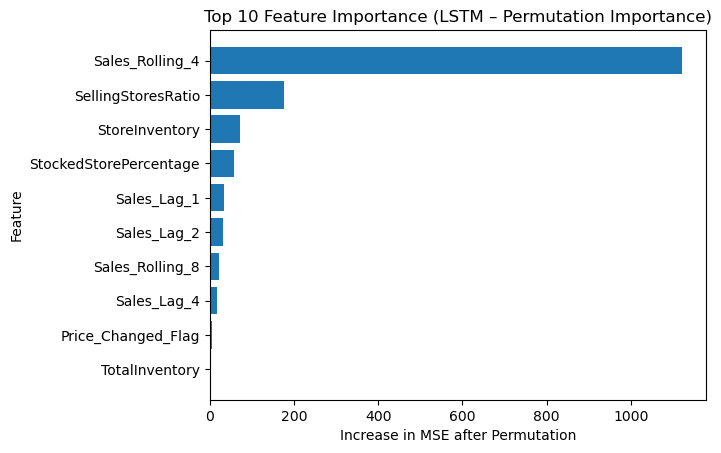

In [50]:
importance_df = (
    pd.DataFrame.from_dict(feature_importance, orient="index", columns=["Importance"])
    .sort_values(by="Importance", ascending=False))
print(importance_df)
top_features = importance_df.head(10)
plt.figure()
plt.barh(
    top_features.index,
    top_features["Importance"])
plt.gca().invert_yaxis()  
plt.title("Top 10 Feature Importance (LSTM – Permutation Importance)")
plt.xlabel("Increase in MSE after Permutation")
plt.ylabel("Feature")
plt.show()

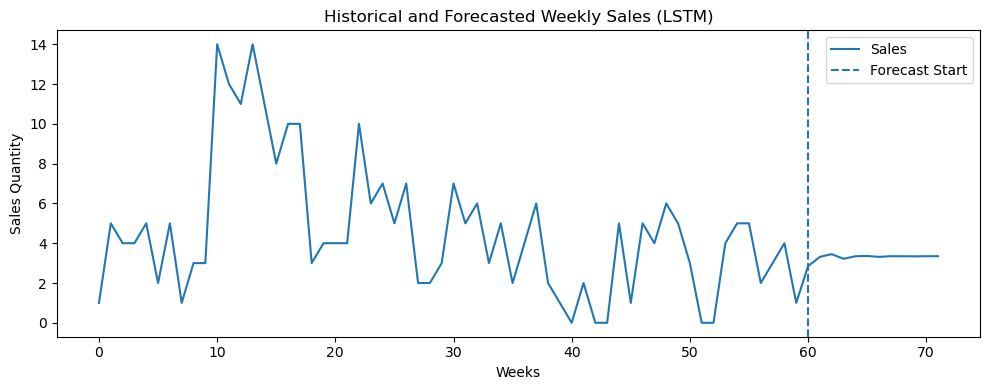

In [56]:
history_window = 60     # last 60 weeks shown
forecast_horizon = 12  # future weeks to predict
historical_sales_trimmed = (
    final_merged_df["SalesQuantity"]
    .iloc[-history_window:]
    .values)
# RECURSIVE LSTM FORECAST
current_features = X.iloc[-1].copy()
future_sales_pred = []
for _ in range(forecast_horizon):

    # Scale features
    X_scaled = scaler_X.transform(
        current_features.values.reshape(1, -1))
    # Reshape for LSTM (samples, timesteps, features)
    X_lstm = X_scaled.reshape(
        (1, 1, X_scaled.shape[1]))
    # Predict
    y_pred_scaled = model.predict(X_lstm, verbose=0)
    y_pred = scaler_y.inverse_transform(
        y_pred_scaled
    )[0, 0]
    future_sales_pred.append(y_pred)
    # UPDATE LAG FEATURES
    current_features["Sales_Lag_4"] = current_features["Sales_Lag_2"]
    current_features["Sales_Lag_2"] = current_features["Sales_Lag_1"]
    current_features["Sales_Lag_1"] = y_pred
    # UPDATE ROLLING FEATURES
    current_features["Sales_Rolling_4"] = (
        current_features["Sales_Lag_1"] +
        current_features["Sales_Lag_2"] +
        current_features["Sales_Lag_4"]
    ) / 3
# COMBINE HISTORY + FORECAST
combined_sales = np.concatenate(
    [historical_sales_trimmed, np.array(future_sales_pred)])
weeks = np.arange(len(combined_sales))
forecast_start_week = len(historical_sales_trimmed)
# PLOT
plt.figure(figsize=(10, 4))
plt.plot(weeks, combined_sales, label="Sales")
plt.axvline(
    x=forecast_start_week,
    linestyle="--",
    label="Forecast Start")
plt.title("Historical and Forecasted Weekly Sales (LSTM)")
plt.xlabel("Weeks")
plt.ylabel("Sales Quantity")
plt.legend()
plt.tight_layout()
plt.show()